In [5]:
import numpy as np
import pandas as pd
### cs109default ### 
import random
random.seed(112358)
import matplotlib.pyplot as plt
import math
import copy
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 
from sklearn import tree
%matplotlib inline
import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
from sklearn.utils import shuffle

In [87]:
num_artifacts = 4
class Card:
    def __init__(self, points, danger, artifact):
        # Number of points
        self.points = points
        # Type of danger (choose from 5)
        self.danger = danger
        # Is it an artifact or not
        self.artifact = artifact

    def show(self):
        # Show value of card:
        if self.points != 0:
            print("Treasure! Value: {}".format(self.points))
        if self.danger != None:
            print("Danger: {}".format(self.danger))
        if self.artifact:
            print("Artifact")

dangers = ['Mummy', "Fire", "Avalanche", "Serpent", "Spiders"]

num_dangers = 3

players = ['A','B', 'C', 'D', 'E']

class Deck:
    def __init__(self, num_artifacts):
        self.cards = []
        self.build()

    def build(self):
        # Insert Dangers
        for danger in dangers:
            for i in range(0, num_dangers):
                self.cards.append(Card(0, danger, None))
        #Insert treasure cards
        treasures = [1,2,3,4,5,5,7,7,9,11,11,13,14,15,17]
        for treasure in treasures:
                self.cards.append(Card(treasure, None, None))
        #Insert Artifacts
        for i in range (0, num_artifacts):
            self.cards.append(Card(0, None, True))

    def shows(self):
        for c in self.cards:
            c.show()
            
    def shuffle(self):
        for i in range(len(self.cards) -1, 0, -1):
            r = random.randint(0,i)
            #Swap cards
            self.cards[i], self.cards[r] = self.cards[r], self.cards[i]
    def draw (self):
        return self.cards.pop()


class Player:
    def __init__(self, player, strat):
        self.name = player
        self.score = 0
        self.loot = 0
        # Variables AI can use to make decisions
        self.number_dangers = 0
        self.num_players = 0
        self.expected_value = 0
        self.leader_score = 0
        self.strat = strat#str(input("Enter Strategy: "))
        self.prob_dying = 0
        # Extra gold to be gained from going back
        self.extra = 0
        self.num_artifacts = 0
        self.round_number = 1
        self.decision_df = pd.DataFrame(columns = ['score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts', 'round_number'])
    # Choice of whether to go forward or backward
    # https://gist.github.com/garrettdreyfus/8153571
    # If player type is normal, propmpts user for input, else makes choice
    # based off of AI strategy
    def choose(self):
        if self.strat == "normal":
            while "invalid":
                print("Make a choice {}".format(self.name))
                print("Your current score is {}". format(self.score))
                print("Your current loot is {}\n\n\n\n\n".format(self.loot))
                check = str(input("Proceed into Temple? (Y/N):")).lower().strip()
                if check[0] == 'y':
                    return True
                elif check[0] == 'n':
                    return False
                else:
                    print('Invalid Input')
        elif self.strat == "AI Basic":

            a = random.random()
            if a < 0.8:
                return True
            else:
                return False
                                        
        elif self.strat == "AI 2nd-Gen":
            self.decision_df = self.decision_df.append({'score':self.score, 'loot':self.loot, 'num_dangers':self.number_dangers, 'num_players':self.num_players, 'expected_value':self.expected_value, 'leader_score':self.leader_score, 'prob_dying':self.prob_dying, 'extra':self.extra, 'num_artifacts':self.num_artifacts,'round_number':self.round_number}, ignore_index = True)
            y_predict = (gen2.predict_proba(self.decision_df)>0.675)[0][1]
            # Clear dataframe = 
            self.decision_df = pd.DataFrame(columns = ['score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts', 'round_number'])
            a = random.random()
            if a < 0.9:
                return y_predict
            else:
                return not y_predict
        elif self.strat == 'AI 3rd-Gen':
            self.decision_df = self.decision_df.append({'score':self.score, 'loot':self.loot, 'num_dangers':self.number_dangers, 'num_players':self.num_players, 'expected_value':self.expected_value, 'leader_score':self.leader_score, 'prob_dying':self.prob_dying, 'extra':self.extra, 'num_artifacts':self.num_artifacts,'round_number':self.round_number}, ignore_index = True)
            y_predict = (gen3.predict_proba(self.decision_df)>0.675)[0][1]
            # Clear dataframe = 
            self.decision_df = pd.DataFrame(columns = ['score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts', 'round_number'])
            a = random.random()
            if a < 0.9:
                return y_predict
            else:
                return not y_predict
            
            
    # Player gains loot from treasure cards
    def add_loot(self, loot_share):
        self.loot += loot_share
    # Player retreats and transfers loot to tent

    def retreat(self):
        # Convert loot to score
        self.score += self.loot
        # Set loot = to 0 
        self.loot = 0

    def die(self):
        self.loot = 0

# Game engines runs a game
class Game:
    # Input number of players
    def __init__(self, player_number):
        self.players = []
        for i in range(0, player_number):
            player = Player(players[i], strategies[i])
            self.players.append(player)
        # Create player object for each player
        self.round_results = pd.DataFrame(columns = ['name','score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts', 'round_number','decision'])
        self.game_results = pd.DataFrame(columns = ['name','score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts', 'round_number','decision'])
        # Round function
        self.artifacts_taken = 0 
        
    def Round(self,round_number):
        # Build and shuffle a deck
        #print('Round {}:'.format(round_number))
        #Create Dataframe to store results
        results_temp = self.round_results
        deck = Deck(round_number - self.artifacts_taken)
        deck.shuffle()
        extra = 0
        dangers_ = []
        num_artifacts = 0
        counter = 0
        # Total Value of all treasure cards
        value = 124
        # Repeat until all players have left or death occurs
        while "round is active":
        # Get input from all players
            if counter == 0:
                # Active players will be a list of the indices of the players in self.players who are active
                active_players = [i for i in range(0, len(self.players))]

            counter += 1
            # List of players who are leaving
            leaving_players = []

            for player in active_players:
                choice = self.players[player].choose()
                #print(active_players)
                if choice == False:
                    results_temp = results_temp.append({'name':self.players[player].name,'score':self.players[player].score, 'loot':self.players[player].loot, 'num_dangers':self.players[player].number_dangers, 'num_players':self.players[player].num_players, 'expected_value':self.players[player].expected_value, 'leader_score':self.players[player].leader_score, 'prob_dying':self.players[player].prob_dying, 'extra':self.players[player].extra, 'num_artifacts':self.players[player].num_artifacts,'round_number':round_number, 'decision': 0},ignore_index = True)
                    # Update players still in game
                    leaving_players.append(player)
                elif choice == True:
                    results_temp = results_temp.append({'name':self.players[player].name,'score':self.players[player].score, 'loot':self.players[player].loot, 'num_dangers':self.players[player].number_dangers, 'num_players':self.players[player].num_players, 'expected_value':self.players[player].expected_value, 'leader_score':self.players[player].leader_score, 'prob_dying':self.players[player].prob_dying, 'extra':self.players[player].extra, 'num_artifacts':self.players[player].num_artifacts,'round_number':round_number, 'decision': 1},ignore_index = True)
                    # Remove player from active players
                    # Why is this removing from self.players as well
            for player in leaving_players:
                active_players.remove(player)
            # Handle Leaving players
            num_leaving = len(leaving_players)
            if num_leaving != 0:
                leaving_split = math.floor(extra/num_leaving)
                if num_artifacts != 0:
                    artifact_split = math.floor(num_artifacts/num_leaving)
                    self.artifacts_taken = self.artifacts_taken + num_artifacts
                    if artifact_split !=0:
                        num_artifacts = num_artifacts % artifact_split
                else:
                    artifact_split = 0
            else:
                leaving_split = 0
            if leaving_split != 0:
                extra = extra % leaving_split
            for player in leaving_players:
                self.players[player].add_loot(leaving_split)
                if self.artifacts_taken < 4:
                    self.players[player].add_loot(5 * artifact_split)
                else:
                    self.players[player].add_loot(10 * artifact_split)
                self.players[player].retreat()
            # Make sure there are players still active
            num_players = len(active_players)
            if (num_players == 0):
                self.game_results = self.game_results.append(results_temp, ignore_index = True)
                active_players =  [i for i in range(0, len(self.players))]
                return False
            # Draw card off of deck
            card = deck.draw()
            #card.show()
            # If danger update danger
            if card.danger != None:
                # If death end round
                if card.danger in dangers_:
                    #print("You died to {}".format(card.danger))
                    self.game_results = self.game_results.append(results_temp, ignore_index = True)
                    for player in active_players:
                        self.players[player].die()
                    active_players = [i for i in range(0, len(self.players))]
                    return False
                else:
                    dangers_.append(card.danger)
            # If card is artifact, print number of artifacts.

            if card.artifact:
                num_artifacts += 1

            # If treasure split treasures
            split = math.floor(card.points / num_players)

            # Add loot for active players
            for player in active_players:
                self.players[player].add_loot(split)
            # Update treaure on path
            extra += (card.points % num_players)

            # Calculate Expected value of next card
            value = value - card.points
            # 30 - counter is the number of cards left in deck
            ev = value/(30 - counter)
            # Calculate score of player in the lead
            scores = []
            for player in self.players:
                scores.append(player.score)
            prob_dying = (2*len(dangers_))/(30-counter)
            # Update player objects with information that they can make decicions off of
            for player in active_players:
                self.players[player].number_dangers = len(dangers_)
                self.players[player].num_players = len(active_players)
                self.players[player].expected_value = ev
                self.players[player].leader_score = max(scores)
                self.players[player].prob_dying = prob_dying
                self.players[player].extra = extra
                self.players[player].num_artifacts = num_artifacts
                self.players[player].round_number = round_number
        

    # Run Appropriate Number of Rounds
    def play_game(self):
        # Run 4 Rounds
        for i in range(0,5):
            self.Round(i+1)

        scores = []
        #print(self.players)
        for player in self.players:
            #print("{} has {} points".format(player.name, player.score))
            scores.append(player.score)
            player.score = 0
        winner = self.players[scores.index(max(scores))].name
        #print("Winner is {}".format(winner))
        winner_results = self.game_results[self.game_results['name'] == winner]
        self.game_results = pd.DataFrame(columns = ['name','score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts', 'round_number','decision'])
        return winner, winner_results
        # Update results dataframe with moves made by winning plater
        

    # Tally scoress and declare winner.
# Implements a single round of the game

# First Generation
Play AIs making random moves against each other and record the set of moves made by the winning player 

In [25]:
results1 = pd.DataFrame(columns = ['name','score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts','round_number', 'decision'])
strategies = ['AI Basic' for i in range(0, 5)]
winners = []
for i in range(0,2000):
    game = Game(5)
    winner, result = game.play_game()
    winners.append(winner)
    results1 = results1.append(result)

In [29]:
results1.to_csv('Data/gen_1.csv')

In [41]:
from collections import Counter

freqs = Counter(winners)
freqs.values()

dict_values([400, 378, 394, 411, 417])

No handles with labels found to put in legend.


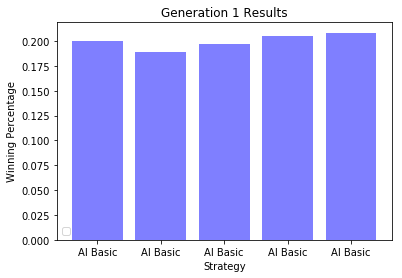

In [53]:
# Plot Winning Frequencies
y = np.array([400, 378, 394, 411, 417])/2000
# Make the plot
x = [i for i, _ in enumerate(strategies)]
plt.bar(x, y, linewidth=3, linestyle="--",
         color="blue", alpha = 0.5)
plt.xlabel(r"Strategy")
plt.ylabel(r"Winning Percentage")
plt.title(r"Generation 1 Results")
plt.legend(loc="lower left")
plt.xticks(x, strategies)
plt.show()

# Second Generation

## Train RF model off of winning moves from first generation

In [59]:
results1 = results1.drop('name', axis = 1)

In [60]:
# Predict correct move from inputs using logistic regression
X_train, X_test, y_train, y_test =train_test_split(results1.loc[:, results1.columns != 'decision'], 
                                                         results1.decision, test_size=0.2, 
                                                         random_state = 109
                                                        )

In [61]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')
random_forest = RandomForestClassifier(n_estimators = 55, max_depth = 10, max_features = 'auto') 
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
import joblib
joblib.dump(random_forest, 'Models/gen2')
gen2 = joblib.load('Models/gen2')

In [67]:
gen2.score(X_test, y_test)

0.8261240144896654

In [71]:
results2 = pd.DataFrame(columns = ['name','score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts','round_number', 'decision'])
strategies = ['AI Basic', 'AI Basic', "AI 2nd-Gen", "AI 2nd-Gen", "AI 2nd-Gen"]
winners = []
for i in range(0,2000):
    game = Game(5)
    winner, result = game.play_game()
    winners.append(winner)
    results2 = results2.append(result)

In [73]:
results2.to_csv('Data/gen2.csv')

In [79]:
freqs = Counter(winners)
freqs.values()

dict_values([504, 498, 488, 239, 271])

No handles with labels found to put in legend.


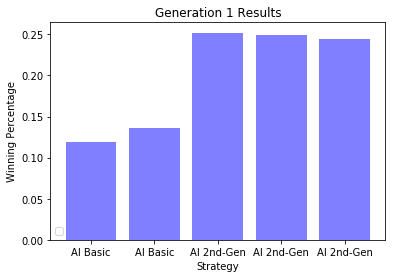

In [80]:
y = np.array([239, 271,504, 498, 488])/2000
# Make the plot
x = [i for i, _ in enumerate(strategies)]
plt.bar(x, y, linewidth=3, linestyle="--",
         color="blue", alpha = 0.5)
plt.xlabel(r"Strategy")
plt.ylabel(r"Winning Percentage")
plt.title(r"Generation 1 Results")
plt.legend(loc="lower left")
plt.xticks(x, strategies)
plt.show()

# 3rd Generation

In [74]:
results2 = results2.drop('name', axis = 1)

In [81]:
# Predict correct move from inputs using logistic regression
X_train2, X_test2, y_train2, y_test2 =train_test_split(results2.loc[:, results2.columns != 'decision'], 
                                                         results2.decision, test_size=0.2, 
                                                         random_state = 109
                                                        )

In [82]:
y_train2 = y_train2.astype('int')
y_test2 = y_test2.astype('int')
gen3 = RandomForestClassifier(n_estimators = 55, max_depth = 10, max_features = 'auto') 
gen3.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [84]:
joblib.dump(gen3,'Models/gen3')

['Models/gen3']

In [94]:
results3 = pd.DataFrame(columns = ['name','score', 'loot', 'num_dangers', 'num_players', 'expected_value', 'leader_score', 'prob_dying', 'extra', 'num_artifacts','round_number', 'decision'])
strategies = ["AI 2nd-Gen", "AI 2nd-Gen", "AI 3rd-Gen","AI 3rd-Gen", "AI 3rd-Gen"]
winners = []
for i in range(0,2000):
    game = Game(5)
    winner, result = game.play_game()
    winners.append(winner)
    results3 = results3.append(result)

In [96]:
results3.to_csv('Data/gen_3.csv')

In [97]:
freqs = Counter(winners)
freqs.values()

dict_values([398, 453, 415, 362, 372])

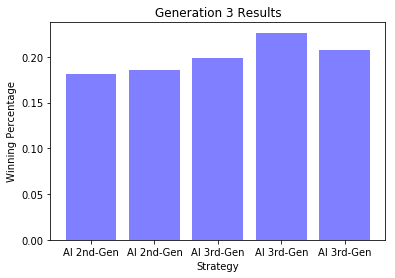

In [100]:
y = np.array([362, 372,398, 453, 415])/2000
# Make the plot
x = [i for i, _ in enumerate(strategies)]
plt.bar(x, y, linewidth=3, linestyle="--",
         color="blue", alpha = 0.5)
plt.xlabel(r"Strategy")
plt.ylabel(r"Winning Percentage")
plt.title(r"Generation 3 Results")
plt.xticks(x, strategies)
plt.show()

# 4th Generation